# Retrosynthetic planning

This tutorial demonstrates how retrosynthetic planning can be performed for target molecules in SynPlanner. For retrosynthetic planning, the retrosynthetic models trained with the previous tutorials can be used. Alternatively,  the pre-trained retrosynthetic models downloaded from SynPlanner can be used.

## Basic recommendations

**1. The "Evaluation first" search strategy is not compatible with the rollout evaluation**

In ``SynPlanner``, there are two main search strategies implemented - the "Expansion first" and "Evaluation first" strategy. These are the strategies for navigating the search tree. "Expansion first" prioritizes the expansion of new nodes and assigns to each new node the default value. "Evaluation first" prioritizes the evaluation of each new node first. Notice, that the usage of the "Evaluation first" strategy with the current implementation of the rollout function in ``SynPlanner`` is not reasonable in terms of the total search time because of the time-consuming execution of the rollout function. Also, the current implementation of the rollout function may mislead the search in the case of the "Evaluation first" strategy due to the limited explanation of the tree in rollout simulations. Therefore, the current recommendation is to use the "Evaluation first" strategy with value network evaluation only.

**2. Try more search iterations (and longer search time) with complex molecules, a limited set of reaction rules, or building blocks**

Some target molecules (usually more complex and bigger molecules) require longer tree searches to be successfully solved and may require longer retrosynthesis routes. The same is true, if there is only a mall set of reaction rules or building blocks, which again requires for longer analysis to find the proper combination of reaction rules leading to the limited amount of building blocks. In these cases, the increase in the number of search iterations may help to find the successful retrosynthesis route for the given molecule.

**3. Currently retrosynthesis planning results in many similar retrosynthetic routes**

Currently, there is no implementation of the retrosynthesis routes clustering in ``SynPlanner``. It may lead to the generation of many similar retrosynthesis routes for the target molecule.

In [4]:
#@title SynPlanner Installation
# %%bash

# git clone https://github.com/Laboratoire-de-Chemoinformatique/SynPlanner.git
# cd SynPlanner/
# pip install -q .

## 1. Set up input and output data locations

The ``SynPlanner`` input data will be downloaded from the ``HuggingFace`` repository to the specified directory.

For the retrosynthetic planning the following data and files are needed:
    
| Data / Files | Description |
| --- | --- |
| Reaction rules  | Extracted reaction rules for precursors dissection in retrosynthetic planning |
| Policy network  | Trained ranking or filtering policy network for node expansion in tree search |
| Value network   | Trained value neural network for node evaluation in tree search (optional, the default evaluation method is rollout) |
| Building blocks | Set of building block molecules, which are used as terminal materials in the retrosynthetic route planning |

In [5]:
from pathlib import Path
from synplan.utils.loading import download_all_data

# download SynPlanner data
data_folder = Path("synplan_data").resolve()
download_all_data(save_to=data_folder)

# input data
# You can use the input data:
# 1. Curated USPTO data, extracted reaction rules, pretrained policy network and building blocks from downloaded data
# 2. Use curated USPTO data, extracted reaction rules, pretrained policy network prepared with tutorials

USE_DOWNLOAD_DATA = True # is False if you want to use the data and models from previous tutorial steps
if USE_DOWNLOAD_DATA:
    # input data
    ranking_policy_network = data_folder.joinpath("uspto/weights/ranking_policy_network.ckpt").resolve(strict=True)
    reaction_rules_path = data_folder.joinpath("uspto/uspto_reaction_rules.pickle")
    # planning reslts folder
    results_folder = Path("planning_with_downloaded_data").resolve()
    results_folder.mkdir(exist_ok=True)
else:
    # input data
    tutorial_results_folder = Path("tutorial_results").resolve()
    ranking_policy_network = tutorial_results_folder.joinpath("ranking_policy_network/policy_network.ckpt").resolve(strict=True)
    reaction_rules_path = tutorial_results_folder.joinpath("uspto_reaction_rules.pickle")
    # planning reslts folder
    results_folder = Path("planning_with_tutorial_data").resolve()
    results_folder.mkdir(exist_ok=True)

# Building blocks file with IDs - supports multiple formats:
#   .sdf      - Uncompressed SDF (largest file size: ~141 MB)
#   .sdf.gz   - GZIP compressed (recommended - ~10x smaller: ~14 MB)
#   .sdf.zip  - ZIP compressed (also supported: ~14 MB)
#
# To create a gzip compressed version, run in terminal:
#   gzip -k building_blocks_em_sa_ln_with_ids.sdf

# Using GZIP compressed version (recommended)
building_blocks_sdf_path = data_folder.joinpath("building_blocks/building_blocks_em_sa_ln_with_ids.sdf.gz")

# Alternative formats:
# building_blocks_sdf_path = data_folder.joinpath("building_blocks/building_blocks_em_sa_ln_with_ids.sdf")      # Uncompressed
# building_blocks_sdf_path = data_folder.joinpath("building_blocks/building_blocks_em_sa_ln_with_ids.sdf.zip")  # ZIP compressed

Fetching 25 files:   0%|          | 0/25 [00:00<?, ?it/s]

### Loading building blocks from SDF with IDs

We load building blocks from an SDF file that contains molecule IDs. This allows us to label building blocks in route visualizations with their unique identifiers.

In [6]:
from rdkit import Chem
from CGRtools import smiles as read_cgr_smiles
from synplan.chem.utils import safe_canonicalization
import gzip
import zipfile
import tempfile
import os

def load_building_blocks_with_ids(sdf_path):
    """
    Load building blocks from an SDF file and extract both SMILES and IDs.
    Supports: .sdf, .sdf.gz (gzip), and .sdf.zip (zip) formats.
    
    Args:
        sdf_path: Path to SDF file (can be .sdf, .sdf.gz, or .sdf.zip)
    
    Returns:
        building_blocks: frozenset of canonical SMILES (for tree search)
        smiles_to_id: dict mapping canonical SMILES to building block IDs
    """
    sdf_path = str(sdf_path)
    building_blocks_set = set()
    smiles_to_id = {}
    
    # Determine file type and get appropriate supplier
    if sdf_path.endswith('.sdf.gz') or sdf_path.endswith('.gz'):
        # GZIP compressed SDF - most efficient format
        print(f"Loading from gzip-compressed SDF: {sdf_path}")
        with gzip.open(sdf_path, 'rt') as gz_file:
            # Read entire content and use SDMolSupplier from text
            sdf_content = gz_file.read()
        suppl = Chem.SDMolSupplier()
        suppl.SetData(sdf_content)
        
    elif sdf_path.endswith('.zip'):
        # ZIP compressed SDF
        print(f"Loading from zip-compressed SDF: {sdf_path}")
        with zipfile.ZipFile(sdf_path, 'r') as zip_file:
            # Find the SDF file inside the zip
            sdf_files = [f for f in zip_file.namelist() if f.endswith('.sdf')]
            if not sdf_files:
                raise ValueError(f"No .sdf file found in {sdf_path}")
            # Use the first SDF file found
            sdf_filename = sdf_files[0]
            print(f"  Extracting: {sdf_filename}")
            with zip_file.open(sdf_filename) as sdf_file:
                sdf_content = sdf_file.read().decode('utf-8')
        suppl = Chem.SDMolSupplier()
        suppl.SetData(sdf_content)
        
    else:
        # Regular uncompressed SDF
        print(f"Loading from SDF: {sdf_path}")
        suppl = Chem.SDMolSupplier(sdf_path)
    
    # Process molecules
    for mol in suppl:
        if mol is None:
            continue
        try:
            # Get the ID from the molecule
            mol_id = mol.GetProp("ID") if mol.HasProp("ID") else mol.GetProp("_Name")
            
            # Get canonical SMILES using RDKit
            rdkit_smiles = Chem.MolToSmiles(mol)
            
            # Convert to CGRtools canonical SMILES for consistency with SynPlanner
            try:
                cgr_mol = read_cgr_smiles(rdkit_smiles)
                cgr_mol = safe_canonicalization(cgr_mol)
                canonical_smiles = str(cgr_mol)
            except:
                canonical_smiles = rdkit_smiles
            
            building_blocks_set.add(canonical_smiles)
            smiles_to_id[canonical_smiles] = mol_id
        except Exception as e:
            continue
    
    print(f"Loaded {len(building_blocks_set)} building blocks with IDs")
    return frozenset(building_blocks_set), smiles_to_id

# Load building blocks with IDs
# Supports: .sdf, .sdf.gz (recommended for compression), or .sdf.zip
building_blocks, smiles_to_id_map = load_building_blocks_with_ids(building_blocks_sdf_path)

Loading from gzip-compressed SDF: /Users/ganeshshahane/Work/RetroChem/colab/synplan_data/building_blocks/building_blocks_em_sa_ln_with_ids.sdf.gz


[15:02:50] WARNING: not removing hydrogen atom without neighbors
[15:02:50] WARNING: not removing hydrogen atom without neighbors
[15:02:50] WARNING: not removing hydrogen atom without neighbors
[15:02:50] WARNING: not removing hydrogen atom without neighbors
[15:02:50] Unusual charge on atom 0 number of radical electrons set to zero
[15:02:50] Unusual charge on atom 0 number of radical electrons set to zero
[15:02:50] WARNING: not removing hydrogen atom without neighbors
[15:02:50] WARNING: not removing hydrogen atom without neighbors


Loaded 180799 building blocks with IDs


## 2. Retrosynthesis configuration

The retrosynthesis in SynPlanner is represented by `Tree` class, which requires:

* loaded building blocks provided as CGRtools `MolecularContainer` object
* loaded reaction rules provided as CGRtools `Reactor` objects
* loaded expansion function represented as trained policy network.
* loaded evaluations function represented as rollout or trained value network.
* tree configuration of SynPlanner `TreeConfig` object
* target molecule provided as CGRtools `MolecularContainer` object

### Loading building blocks

Building blocks can be loaded with the `load_building_blocks` function. They can be loaded from a `.pickle` file containing already standardized molecules as `MolecularContainer` or from a `.smi` file containing SMILES. 

<div class="alert alert alert-warning">
<b>Warn</b> 
    
The first loading of building blocks can be long, especially if they loaded from SMILES file.
</div>

### Loading reaction rules

Reaction rules can be loaded with `load_reaction_rules` function that will automatically convert them to `Reactor` object of CGRtools. Currently, they are loaded from `.pickle` file, that was generated during reaction rule extraction. The loading from SMARTS would be added in the next versions. 

For more information, please visit rules extraction tutorial.

In [7]:
from synplan.utils.loading import load_reaction_rules

reaction_rules = load_reaction_rules(reaction_rules_path)

### Loading policy function

Policy function can be loaded directly from the weights file ends with `.ckpt`, as it includes all configuration for the policy network used for its training 

<div class="alert alert-info">
<b>Note</b>   

    
The `PolicyNetworkConfig` parameters are ignored when the `.ckpt` file is provided, as it already contains all parameter values
</div>

For more info, please visit ranking policy training tutorial. 

In [8]:
from synplan.utils.loading import load_policy_function

policy_function = load_policy_function(weights_path=ranking_policy_network)

Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint synplan_data/uspto/weights/ranking_policy_network.ckpt`


### Search configuration

The next step is to configure the Monte-Carlo Tree Search. We do this using the `TreeConfig` class in ``SynPlanner``. This class allows for the specification of various parameters and settings for the MCTS.

More details about MCTS configuration in ``SynPlanner`` can be found **here** in official document.

In [9]:
from synplan.utils.config import TreeConfig

tree_config = TreeConfig(
    search_strategy="expansion_first",
    max_iterations=300,
    max_time=120,
    max_depth=9,
    min_mol_size=1,
    init_node_value=0.5,
    ucb_type="uct",
    c_ucb=0.1,
)

### Loading evaluation function

The evaluation strategy determines how nodes are scored during tree search. We create an evaluation configuration that contains all necessary dependencies.

In [10]:
from synplan.utils.config import RolloutEvaluationConfig
from synplan.utils.loading import load_evaluation_function

# Create evaluation configuration with all dependencies
eval_config = RolloutEvaluationConfig(
    policy_network=policy_function,
    reaction_rules=reaction_rules,
    building_blocks=building_blocks,
    min_mol_size=tree_config.min_mol_size,
    max_depth=tree_config.max_depth,
)

# Create evaluator from config
evaluation_function = load_evaluation_function(eval_config)

### Loading target molecule

The target molecule need to be loaded as `MolecularContainer` and **must be standardized**. The easiest way is to use `smiles` function availible in CGRtools. 

For the search with multiple molecules, please visit advanced retrosynthetic planning tutorial.

In [11]:
from synplan.chem.utils import mol_from_smiles

# let's take capivasertib used as anti-cancer medication for the treatment 
# of breast cancer and approved by FDA in 2023
example_smiles = "NC1(C(=O)N[C@@H](CCO)c2ccc(Cl)cc2)CCN(c2nc[nH]c3nccc2-3)CC1"

target_molecule = mol_from_smiles(example_smiles, clean2d=True, standardize=True, clean_stereo=True)

### Initialising tree

Next, we initialise the `Tree` object, providing target molecule and loaded reaction rules, building blocks, expansion function, and evaluation strategy.

The `evaluation_function` parameter accepts an evaluation strategy object created from the evaluation configuration.

In [12]:
from synplan.mcts.tree import Tree

tree = Tree(
    target=target_molecule,
    config=tree_config,
    reaction_rules=reaction_rules,
    building_blocks=building_blocks,
    expansion_function=policy_function,
    evaluation_function=evaluation_function,
)

## 3. Running retrosynthetic planning

The `Tree` object is iterable, like `List` in Python. Each iteration represents one MCTS iteration, after which 2 values are returned:

* `solved` is boolean, if `True` then a successful route was found during the current iteration.
* `node_id` is a list of indices of leaf nodes generated during the current iteration.

Once search is finished, the tree will print some stats:

In [13]:
tree_solved = False
for solved, node_id in tree:
    if solved:
        tree_solved = True
tree

  0%|          | 0/300 [00:00<?, ?it/s]

Tree for: c1cc(ccc1Cl)C(CCO)NC(C2(CCN(CC2)c3c4cc[nH]c4ncn3)N)=O
Time: 31.1 seconds
Number of nodes: 3799
Number of iterations: 300
Number of visited nodes: 300
Number of found routes: 109

### Visualizing predicted retrosynthetic routes

After the tree search is complete, we can visualize the found retrosynthesis paths. The visualization uses the `get_route_svg` function from SynPlanner visualization interface.

In [14]:
from itertools import count, islice
from CGRtools.containers.molecule import MoleculeContainer
from typing import Dict, List, Tuple, Optional
import re
import pickle

# =============================================================================
# Reaction Classification System
# =============================================================================

def classify_reaction_from_smarts(rxn_str: str, rule_id: int = None) -> str:
    """
    Classify a reaction based on its SMARTS-like string representation.
    Uses pattern analysis to identify common reaction types.
    
    Args:
        rxn_str: The SMARTS-like string representation of the reaction
        rule_id: Optional rule ID for display purposes
        
    Returns:
        str: Human-readable reaction name/classification
    """
    try:
        rxn_upper = rxn_str.upper()
        
        # Split into reactants and products
        parts = rxn_str.split('>>')
        if len(parts) != 2:
            return f"Transformation"
        
        reactant_part = parts[0]
        product_part = parts[1]
        
        # Count products (separated by '.')
        num_products = len(product_part.split('.'))
        
        # =========================================
        # Amide-related reactions
        # =========================================
        if re.search(r'N.*C.*=O|C\(=O\).*N|NC\(=O\)|C.*N.*=O', rxn_upper):
            if 'CL' in rxn_upper or ';D1;ZS]' in rxn_str:
                if num_products > 1:
                    return "Amide Hydrolysis"
                return "Amide Coupling"
            elif num_products > 1:
                return "Amide Cleavage"
            return "Amide Formation"
        
        # =========================================
        # Ester-related reactions
        # =========================================
        if re.search(r'C\(=O\)O|OC\(=O\)|COO', rxn_upper) and 'N' not in rxn_upper:
            if num_products > 1:
                return "Ester Hydrolysis"
            return "Esterification"
        
        # =========================================
        # Sulfonamide reactions
        # =========================================
        if re.search(r'S.*=O.*=O.*N|NS.*O', rxn_upper):
            if num_products > 1:
                return "Sulfonamide Cleavage"
            return "Sulfonamide Formation"
        
        # =========================================
        # Halogen-related reactions
        # =========================================
        halogen_pattern = r'CL;|BR;|I;D1|F;D1'
        reactant_halogens = len(re.findall(halogen_pattern, rxn_upper.split('>>')[0]))
        product_halogens = len(re.findall(halogen_pattern, rxn_upper.split('>>')[1])) if '>>' in rxn_upper else 0
        
        if product_halogens > reactant_halogens:
            return "Halogenation"
        elif reactant_halogens > product_halogens:
            if 'N;' in rxn_upper:
                return "N-Alkylation"
            elif 'O;' in rxn_upper and 'C=O' not in rxn_str:
                return "O-Alkylation"
            elif 'S;' in rxn_upper:
                return "S-Alkylation"
            elif num_products > 1:
                return "Dehalogenation"
            else:
                return "Substitution"
        
        # =========================================
        # Boron-containing (Cross-coupling)
        # =========================================
        if 'B' in rxn_upper and ('O' in rxn_upper or '[B' in rxn_str):
            return "Cross-Coupling"
        
        # =========================================
        # Aromatic substitution (Za = aromatic)
        # =========================================
        if 'ZA' in rxn_upper:
            if 'N;' in rxn_upper or '-[N' in rxn_str:
                return "Aromatic Amination"
            elif 'O;' in rxn_upper or '-[O' in rxn_str:
                return "Aromatic Etherification"
            elif 'S;' in rxn_upper:
                return "Aromatic Thioether"
            return "Aromatic Substitution"
        
        # =========================================
        # Carbonyl reactions
        # =========================================
        if '=O' in rxn_str:
            if 'ZD' in rxn_upper:  # Double bond hybridization
                if num_products > 1:
                    return "Carbonyl Addition"
                return "Carbonyl Transformation"
        
        # =========================================
        # Ether reactions
        # =========================================
        if re.search(r'C.*-O-.*C|C-O-C', rxn_str) and 'C=O' not in rxn_str:
            if num_products > 1:
                return "Ether Cleavage"
            return "Ether Formation"
        
        # =========================================
        # Reduction/Oxidation patterns
        # =========================================
        # Reduction: C=O in reactant, C-O in product
        if '=O]' in reactant_part and '-O' in product_part:
            return "Reduction"
        # Oxidation: C-O in reactant, C=O in product
        if '-O' in reactant_part and '=O]' in product_part:
            return "Oxidation"
        
        # =========================================
        # General patterns based on product count
        # =========================================
        if num_products >= 2:
            return "Bond Cleavage"
        elif num_products == 1:
            # Check if it's a rearrangement or transformation
            reactant_atoms = len(re.findall(r'\[', reactant_part))
            product_atoms = len(re.findall(r'\[', product_part))
            if abs(reactant_atoms - product_atoms) <= 1:
                return "Rearrangement"
            return "Transformation"
        
        return "Chemical Reaction"
        
    except Exception as e:
        return f"Reaction"


def load_reaction_rules_with_smarts(rules_path: str) -> Dict[int, str]:
    """
    Load reaction rules and extract their SMARTS representations for classification.
    
    Args:
        rules_path: Path to the reaction rules pickle file
        
    Returns:
        Dict mapping rule_id -> SMARTS string
    """
    with open(rules_path, "rb") as f:
        rules_data = pickle.load(f)
    
    rule_id_to_smarts = {}
    for i, item in enumerate(rules_data):
        if isinstance(item, tuple):
            rxn_container = item[0]
        else:
            rxn_container = item
        
        # Get SMARTS-like string representation
        rule_id_to_smarts[i] = str(rxn_container)
    
    return rule_id_to_smarts


def get_rule_id_to_name_map(tree, rules_path=None) -> Dict[int, str]:
    """
    Create a mapping from rule IDs to human-readable reaction names.
    
    Args:
        tree: The MCTS Tree object containing reaction_rules
        rules_path: Path to the reaction rules pickle file for SMARTS access
        
    Returns:
        Dict mapping rule_id -> reaction name string
    """
    rule_id_to_name = {}
    
    # Try to load SMARTS from pickle file
    if rules_path:
        try:
            rule_id_to_smarts = load_reaction_rules_with_smarts(rules_path)
            for rule_id, smarts in rule_id_to_smarts.items():
                rule_id_to_name[rule_id] = classify_reaction_from_smarts(smarts, rule_id)
            return rule_id_to_name
        except Exception as e:
            print(f"Warning: Could not load SMARTS from pickle: {e}")
    
    # Fallback: just use rule IDs
    if hasattr(tree, 'reaction_rules'):
        for rule_id in range(len(tree.reaction_rules)):
            rule_id_to_name[rule_id] = f"Rule #{rule_id}"
    
    return rule_id_to_name


# =============================================================================
# SVG Rendering Functions
# =============================================================================

def render_svg_with_labels(pred, columns, box_colors, smiles_to_id=None, 
                          node_rule_map=None, rule_id_to_name=None):
    """
    Renders an SVG representation of a retrosynthetic route with building block ID labels
    and reaction name labels.
    
    Args:
        pred: Tuple of tuples representing predicted reaction steps (source, target)
        columns: List of lists of Molecule objects for each reaction stage
        box_colors: Dict mapping molecule status to SVG colors
        smiles_to_id: Dict mapping SMILES to building block IDs
        node_rule_map: Dict mapping node indices to rule IDs
        rule_id_to_name: Dict mapping rule IDs to reaction names
    
    Returns:
        str: SVG code for the retrosynthetic route visualization
    """
    x_shift = 0.0
    c_max_x = 0.0
    c_max_y = 0.0
    render = []
    cx = count()
    cy = count()
    arrow_points = {}
    label_positions = []  # Store label positions for building blocks
    
    for ms in columns:
        heights = []
        for m in ms:
            m.clean2d()
            min_x = min(x for x, y in m._plane.values()) - x_shift
            min_y = min(y for x, y in m._plane.values())
            m._plane = {n: (x - min_x, y - min_y) for n, (x, y) in m._plane.items()}
            max_x = max(x for x, y in m._plane.values())
            c_max_x = max(c_max_x, max_x)
            arrow_points[next(cx)] = [x_shift, max_x]
            heights.append(max(y for x, y in m._plane.values()))

        x_shift = c_max_x + 5.0
        y_shift = sum(heights) + 3.0 * (len(heights) - 1)
        c_max_y = max(c_max_y, y_shift)
        y_shift /= 2.0
        
        for m, h in zip(ms, heights):
            m._plane = {n: (x, y - y_shift) for n, (x, y) in m._plane.items()}
            
            max_x = max(x for x, y in m._plane.values()) + 0.9
            min_x = min(x for x, y in m._plane.values()) - 0.6
            max_y = -(max(y for x, y in m._plane.values()) + 0.45)
            min_y = -(min(y for x, y in m._plane.values()) - 0.45)
            x_delta = abs(max_x - min_x)
            y_delta = abs(max_y - min_y)
            
            box = (
                f'<rect x="{min_x}" y="{max_y}" rx="{y_delta * 0.1}" ry="{y_delta * 0.1}" '
                f'width="{x_delta}" height="{y_delta}" stroke="black" stroke-width=".0025" '
                f'fill="{box_colors[m.meta["status"]]}" fill-opacity="0.30"/>'
            )
            
            # Store position for building block labels
            if m.meta.get("status") == "instock" and smiles_to_id:
                smiles = str(m)
                if smiles in smiles_to_id:
                    label_x = (min_x + max_x) / 2
                    label_y = min_y + 0.3  # Position below the box
                    label_positions.append((label_x, label_y, smiles_to_id[smiles]))
            
            arrow_points[next(cy)].append(y_shift - h / 2.0)
            y_shift -= h + 3.0
            depicted_molecule = list(m.depict(embedding=True))[:3]
            depicted_molecule.append(box)
            render.append(depicted_molecule)

    # Calculate mid-X coordinate for arrows
    graph = {}
    for s, p in pred:
        try:
            graph[s].append(p)
        except KeyError:
            graph[s] = [p]
    for s, ps in graph.items():
        mid_x = float("-inf")
        for p in ps:
            s_min_x, s_max, s_y = arrow_points[s][:3]
            p_min_x, p_max, p_y = arrow_points[p][:3]
            p_max += 1
            mid = p_max + (s_min_x - p_max) / 3
            mid_x = max(mid_x, mid)
        for p in ps:
            arrow_points[p].append(mid_x)

    config = MoleculeContainer._render_config
    font_size = config["font_size"]
    font125 = 1.25 * font_size
    width = c_max_x + 4.0 * font_size
    height = c_max_y + 3.5 * font_size
    box_y = height / 2.0
    
    svg = [
        f'<svg width="{0.6 * width:.2f}cm" height="{0.6 * height:.2f}cm" '
        f'viewBox="{-font125:.2f} {-box_y:.2f} {width:.2f} '
        f'{height:.2f}" xmlns="http://www.w3.org/2000/svg" version="1.1">',
        '  <defs>\n    <marker id="arrow" markerWidth="10" markerHeight="10" '
        'refX="0" refY="3" orient="auto">\n      <path d="M0,0 L0,6 L9,3"/>\n    </marker>\n  </defs>',
    ]

    # Store arrow positions for reaction labels
    reaction_label_positions = []
    
    # Draw arrows with reaction labels
    for s, p in pred:
        s_min_x, s_max, s_y = arrow_points[s][:3]
        p_min_x, p_max, p_y = arrow_points[p][:3]
        p_max += 1
        mid_x = arrow_points[p][-1]
        arrow = f"""  <polyline points="{p_max:.2f} {p_y:.2f}, {mid_x:.2f} {p_y:.2f}, {mid_x:.2f} {s_y:.2f}, {s_min_x - 1.:.2f} {s_y:.2f}"
                fill="none" stroke="black" stroke-width=".04" marker-end="url(#arrow)"/>"""
        if p_y != s_y:
            arrow += f'  <circle cx="{mid_x}" cy="{p_y}" r="0.1"/>'
        svg.append(arrow)
        
        # Calculate position for reaction label (on the horizontal part of arrow)
        if node_rule_map and rule_id_to_name:
            # Get rule ID for this step (target node)
            if p in node_rule_map:
                rule_id = node_rule_map[p]
                rxn_name = rule_id_to_name.get(rule_id, f"Rule #{rule_id}")
                # Position label above the arrow, at the midpoint of horizontal segment
                label_x = (p_max + mid_x) / 2
                label_y = p_y - 0.4  # Position above the arrow
                reaction_label_positions.append((label_x, label_y, rxn_name, s, p))
    
    # Draw molecules
    for atoms, bonds, masks, box in render:
        molecule_svg = MoleculeContainer._graph_svg(
            atoms, bonds, masks, -font125, -box_y, width, height
        )
        molecule_svg.insert(1, box)
        svg.extend(molecule_svg)
    
    # Add building block ID labels
    for label_x, label_y, bb_id in label_positions:
        svg.append(
            f'<text x="{label_x:.2f}" y="{label_y:.2f}" '
            f'text-anchor="middle" font-size="0.35" font-family="sans-serif" '
            f'fill="#006400" font-weight="bold">{bb_id}</text>'
        )
    
    # Add reaction name labels
    added_reactions = set()  # Avoid duplicate labels for same reaction
    for label_x, label_y, rxn_name, s, p in reaction_label_positions:
        # Create unique key for this reaction step
        rxn_key = (s, rxn_name)
        if rxn_key not in added_reactions:
            added_reactions.add(rxn_key)
            # Add background for better readability
            text_width = len(rxn_name) * 0.18  # Approximate width
            svg.append(
                f'<rect x="{label_x - text_width/2 - 0.1:.2f}" y="{label_y - 0.25:.2f}" '
                f'width="{text_width + 0.2:.2f}" height="0.35" '
                f'fill="white" fill-opacity="0.85" rx="0.05" ry="0.05"/>'
            )
            svg.append(
                f'<text x="{label_x:.2f}" y="{label_y:.2f}" '
                f'text-anchor="middle" font-size="0.28" font-family="sans-serif" '
                f'fill="#8B0000" font-style="italic">{rxn_name}</text>'
            )
    
    svg.append("</svg>")
    return "\n".join(svg)


def get_route_svg_with_bb_ids(tree, node_id, smiles_to_id, show_reaction_names=True, 
                              rules_path=None):
    """
    Visualizes the retrosynthetic route with building block IDs and reaction names labeled.
    
    Args:
        tree: The built tree
        node_id: The id of the node from which to visualize the route
        smiles_to_id: Dict mapping SMILES to building block IDs
        show_reaction_names: Whether to show reaction names on arrows (default: True)
        rules_path: Path to reaction rules pickle file for SMARTS classification
    
    Returns:
        str: The SVG string with building block and reaction labels
    """
    if node_id not in tree.winning_nodes:
        return None
    
    nodes = tree.route_to_node(node_id)
    
    # Build rule ID to name mapping
    rule_id_to_name = get_rule_id_to_name_map(tree, rules_path) if show_reaction_names else {}
    
    # Set up node types for different box colors
    for n in nodes:
        for precursor in n.new_precursors:
            precursor.molecule.meta["status"] = (
                "instock"
                if precursor.is_building_block(tree.building_blocks)
                else "mulecule"
            )
    nodes[0].curr_precursor.molecule.meta["status"] = "target"
    
    box_colors = {
        "target": "#98EEFF",
        "mulecule": "#F0AB90",
        "instock": "#9BFAB3",
    }

    # Build columns and track which rule was used for each node
    columns = [
        [nodes[0].curr_precursor.molecule],
        [x.molecule for x in nodes[1].new_precursors],
    ]
    pred = {x: 0 for x in range(1, len(columns[1]) + 1)}
    
    # Map node indices to rule IDs based on molecule meta
    node_rule_map = {}
    
    # For the first reaction step (node index 1), get rule from nodes[1]
    for idx, precursor in enumerate(nodes[1].new_precursors, 1):
        if hasattr(precursor.molecule, 'meta') and 'reactor_id' in precursor.molecule.meta:
            node_rule_map[idx] = precursor.molecule.meta['reactor_id']
    
    cx = [
        n
        for n, x in enumerate(nodes[1].new_precursors, 1)
        if not x.is_building_block(tree.building_blocks)
    ]
    size = len(cx)
    nodes_iter = iter(nodes[2:])
    cy = count(len(columns[1]) + 1)
    
    while size:
        layer = []
        for s in islice(nodes_iter, size):
            n = cx.pop(0)
            for x in s.new_precursors:
                layer.append(x)
                m = next(cy)
                if not x.is_building_block(tree.building_blocks):
                    cx.append(m)
                pred[m] = n
                # Track rule ID for this node
                if hasattr(x.molecule, 'meta') and 'reactor_id' in x.molecule.meta:
                    node_rule_map[m] = x.molecule.meta['reactor_id']
        size = len(cx)
        columns.append([x.molecule for x in layer])

    columns = [columns[::-1] for columns in columns[::-1]]
    
    # Remap node_rule_map to match the reversed column indices
    total_nodes = len(pred)
    remapped_rule_map = {}
    for node_idx, rule_id in node_rule_map.items():
        remapped_idx = abs(node_idx - total_nodes)
        remapped_rule_map[remapped_idx] = rule_id
    
    pred = tuple(
        (abs(source - len(pred)), abs(target - len(pred)))
        for target, source in pred.items()
    )
    
    return render_svg_with_labels(pred, columns, box_colors, smiles_to_id, 
                                  remapped_rule_map, rule_id_to_name)

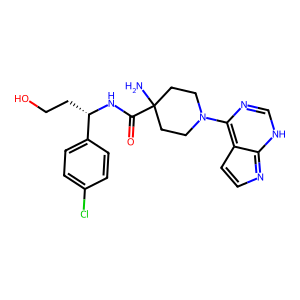

In [15]:
from rdkit import Chem
from rdkit.Chem import Draw

Draw.MolToImage(Chem.MolFromSmiles(example_smiles), size=(300, 300))

In [16]:
from IPython.display import SVG, display

for n, node_id in enumerate(tree.winning_nodes):
    print(
        f"-------- Path starts from node #{node_id} with total route score {tree.route_score(node_id)} --------"
    )
    # Use custom visualization with building block IDs and reaction names
    display(SVG(get_route_svg_with_bb_ids(tree, node_id, smiles_to_id_map, 
                                          show_reaction_names=True,
                                          rules_path=str(reaction_rules_path))))
    if n == 3:
        break

-------- Path starts from node #949 with total route score 0.14383878009740728 --------


-------- Path starts from node #959 with total route score 0.12062824783376923 --------


-------- Path starts from node #960 with total route score 0.12062824783376923 --------


-------- Path starts from node #965 with total route score 0.12062824783376923 --------


In [17]:
# Verify the reaction classifications being applied
# Load SMARTS from the rules file and check classifications
print("Reaction classification examples from this tree:\n")

rule_smarts = load_reaction_rules_with_smarts(str(reaction_rules_path))

# Get unique rule IDs used in this tree
used_rules = list(set(list(tree.nodes_rules.values())))[:15]

for rule_id in used_rules:
    if rule_id in rule_smarts:
        smarts = rule_smarts[rule_id]
        name = classify_reaction_from_smarts(smarts, rule_id)
        print(f"  Rule {rule_id}: {name}")
        print(f"    SMARTS: {smarts[:80]}..." if len(smarts) > 80 else f"    SMARTS: {smarts}")
        print()

Reaction classification examples from this tree:

  Rule 13824: Bond Cleavage
    SMARTS: [C;D1;Zs]-[O;D2;Zs]-[C;D2;Zs]>>[O;D1;Zd]=[S;D4;Zt](=[O;D1;Zd])(-[C;D1;Zs])-[O;D2...

  Rule 513: Halogenation
    SMARTS: [C;D2;Za]:[C;D2;Za]:[N;D2;Za]>>[C;D3;Za](:[N;D2;Za])(-[Cl;D1;Zs]):[C;D2;Za]

  Rule 1: Transformation
    SMARTS: [C;D3;Zd]-[O;D1;Zs]>>[C;D1;Zs]-[C;D2;Zs]-[O;D2;Zs]-[C;D3;Zd]

  Rule 3: Transformation
    SMARTS: [C;D2;Zs]-[N;D2;Zs]-[C;D2;Zs]>>[C]-[C](-[C])(-[C])-[O;D2;Zs]-[C;D3;Zd](-[N;D3;Zs...

  Rule 1538: Transformation
    SMARTS: [O;D1;Zs]-[C;D2;Zs]>>[C]-[C;D4;Zs](-[C])(-[C])-[C;D3;Zd](=[O;D1;Zd])-[O;D2;Zs]-[...

  Rule 23044: Aromatic Amination
    SMARTS: [C;D2;Zs]-[N;D3;Zs](-[C;D2;Zs])-[C;D3;Za](:[N;D2;Za]):[C;D3;Za]>>[C;D2;Zs]-[N;D2...

  Rule 1026: Transformation
    SMARTS: [N;D2;Zs](-[C;D3;Zd])-[C;D2;Zs]>>[C]-[C](-[C])(-[C])-[O;D2;Zs]-[C;D3;Zd](-[N;D3;...

  Rule 1543: Aromatic Amination
    SMARTS: [C;D2;Za]:[C;D3;Za](:[C;D2;Za])-[Cl;D1;Zs]>>[C;D2;Za]:[C;D3;Za](:[